<a href="https://colab.research.google.com/github/carlos-cardoso84/text_classification_pyspark/blob/master/Classification_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLASSIFICAÇÃO TEXTUAL COM O PYSPARK

## DADOS

A base utilizada contém twets sobre o Coronavírus. 

Nela temos a identificação do usuário (UserName, ScreenName), o local (Location), a data do tweet (TweetAt), o texto original (OriginalTweet) e a classificação (Sentiment).

Os dados utilizados estão disponíveis em: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?





## CARREGAMENTO VIA GOOGLE DRIVE

O carregamento dos dados será realizado via pandas

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
path = ('/content/drive/MyDrive/projetos spark/classfication text/data.xls')
df = pd.read_excel(path)

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

## FILTRANDO A BASE

Há 5 classificações diferentes na nossa base. Estamos interessados apenas nas classificações 'Extremely Positive' e 'Extremely Negative' para nosso estudo. Faremos o filtro na base original.

In [4]:
df = df[(df['Sentiment']=='Extremely Negative') | (df['Sentiment']=='Extremely Positive')].reset_index(drop=True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
1,3810,48762,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increas...",Extremely Positive
2,3811,48763,Horningsea,16-03-2020,#horningsea is a caring community. LetÂs ALL ...,Extremely Positive
3,3817,48769,North America,16-03-2020,"Amazon Glitch Stymies Whole Foods, Fresh Groce...",Extremely Positive
4,3819,48771,southampton soxx xxx,16-03-2020,with 100 nations inficted with covid 19 th...,Extremely Negative


## INSTALANDO O PYSPARK

In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=33a87763ebd52bfaccd269a92ece8f98a96f1330047485d8b4fad4572e993346
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


## Iniciando a sessão

É necessário a inicialização de uma SparkSession para iniciar os trabalhos via pyspark

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master('local[*]')\
        .appName('analise_textual')\
        .getOrCreate()



## Spark Dataframe

Precisamos converter nosso Dataframe Pandas em um Spark Dataframe. Selecionaremos também apenas as variáveis de interesse: UserName, OriginalTweet e Sentiment.

In [7]:
df = df[['UserName', 'OriginalTweet',	'Sentiment']]
dados = spark.createDataFrame(df)

In [8]:
dados.show()

+--------+--------------------+------------------+
|UserName|       OriginalTweet|         Sentiment|
+--------+--------------------+------------------+
|    3803|Me, ready to go a...|Extremely Negative|
|    3810|Due to the Covid-...|Extremely Positive|
|    3811|#horningsea is a ...|Extremely Positive|
|    3817|Amazon Glitch Sty...|Extremely Positive|
|    3819|with 100  nations...|Extremely Negative|
|    3821|We have AMAZING C...|Extremely Positive|
|    3822|We have AMAZING C...|Extremely Positive|
|    3824|UK #consumer poll...|Extremely Positive|
|    3826|This morning I te...|Extremely Negative|
|    3828|@7SealsOfTheEnd S...|Extremely Negative|
|    3830|'Hole' Foods...\r...|Extremely Positive|
|    3832|Coronavirus fun f...|Extremely Positive|
|    3839|We're here to pro...|Extremely Positive|
|    3841|CHECK VIDEO ?? ht...|Extremely Negative|
|    3845| Please Share  Kn...|Extremely Positive|
|    3847|Never thought I'd...|Extremely Positive|
|    3849|"Everything weÂr...|

A variável ***dados*** é nosso Spark Dataframe com a identificação do usuário (UserName), o texto publicado no Twitter (OriginalTweet) e a Classificação (Sentiment).

## ANÁLISE EXPLORATÓRIA

In [9]:
print(f"Linhas: {dados.count()} Colunas: {len(dados.columns)}")

Linhas: 12105 Colunas: 3


In [10]:
dados.printSchema()

root
 |-- UserName: long (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)



Nossa base apresenta 12105 tweets (linhas) com as três colunas já mencionadas. UserName apresenta informações no formato ***long*** (forma de representação de números inteiros no pyspark) e as outras duas colunas no formato ***string***.

### Sobre a variável resposta:

In [11]:
dados.groupBy('Sentiment').count().show()

+------------------+-----+
|         Sentiment|count|
+------------------+-----+
|Extremely Negative| 5481|
|Extremely Positive| 6624|
+------------------+-----+



In [12]:
import plotly.express as px

data_pie = dados.groupBy('Sentiment').count().toPandas()
data_pie

fig = px.pie(data_pie, values='count', names='Sentiment', color_discrete_sequence=px.colors.sequential.RdBu,width=800, height=400, hole=.5)
fig.update_layout(title_text ='Distribuition of Labels', title_x=0.45)


fig.show()


Percebe-se um certo equilíbrio entre as duas classificações da base.

Agrupamos a variável resposta (goupBy) e fizemos a contagem de cada label (count) com a transformação do resultado em um pandas dataframe (toPandas) para a utilização do plotly na visualização gráfica.

## TRATAMENTO DOS DADOS

O primeiro passo a ser realizado é o tratamento do texto. Há muitos registros contendo números, pontuações, caracteres especiais que pouco acrescentam na construção do modelo e devem ser retirados. Além disso removeremos todas as partes contendo urls.

Utilizaremos a função regex_replace do pyspark para substituir cada um desses caracteres por um espaçe em branco.

In [13]:
##aplicando na base
import pyspark.sql.functions as f

##removendo os caracteres especiais
dados = dados.withColumn("remove_punctuation", f.regexp_replace("OriginalTweet", r'https?:\/\/.*[\r\n]*', ""))
dados = dados.withColumn("remove_punctuation", f.regexp_replace("remove_punctuation", "[\n\r\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\^0-9]", ""))

dados.show(truncate = False)

+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UserName|OriginalTweet                                                                                                                                                                                                                                                                                                                     |Sentiment         |remove_punctuation                     

Criamos uma nova coluna (remove_punctuation) contendo os tweets sem esses caracteres.

A função ***trim*** remove os espaços em branco no início e no final de cada frase

In [14]:
dados = dados.withColumn('clear_text', f.trim(dados.remove_punctuation))
dados.show(2,truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UserName|OriginalTweet                                                                                                                 

## TOKENIZAÇÃO

O próximo passo é realizar a tokenização, ou seja, dividir a frase toda em palavras ou tokens individuais.

Utilizaremos a função Tokenizer do pyspark. Primeiramente constuiremos o objeto contendo a função com os parâmetros inputCol (variável de entrada) e outputCol (variável de saída).

A variável **tokenizado** contém os dados com essa transformação. A própria função já deixa as letras iniciais em minúsculo, padronizando assim todas as palavras.

In [15]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='clear_text', outputCol = 'tokens')
tokenizado = tokenizer.transform(dados) #já deixa as letras em minusculo


tokenizado.select('clear_text', 'tokens').show()

+--------------------+--------------------+
|          clear_text|              tokens|
+--------------------+--------------------+
|Me ready to go at...|[me, ready, to, g...|
|Due to the Covid ...|[due, to, the, co...|
|horningsea is a c...|[horningsea, is, ...|
|Amazon Glitch Sty...|[amazon, glitch, ...|
|with   nations in...|[with, , , nation...|
|We have AMAZING C...|[we, have, amazin...|
|We have AMAZING C...|[we, have, amazin...|
|UK consumer poll ...|[uk, consumer, po...|
|This morning I te...|[this, morning, i...|
|SealsOfTheEnd Soo...|[sealsoftheend, s...|
|Hole Foodsimages ...|[hole, foodsimage...|
|Coronavirus fun f...|[coronavirus, fun...|
|Were here to prov...|[were, here, to, ...|
|         CHECK VIDEO|      [check, video]|
|Please Share  Kno...|[please, share, ,...|
|Never thought Id ...|[never, thought, ...|
|Everything weÂre...|[everything, weâ...|
|Global food price...|[global, food, pr...|
|Morning everyone ...|[morning, everyon...|
|Of all the things...|[of, all, 

### FREQUÊNCIA DE TOKENS  EM CADA TWEET

Criaremos uma função para a contagem de TOKENS em cada tweet. Criaremos um pandas dataframe para a visualização dessa contagem através de um histograma no Plotly.

In [16]:
from pyspark.sql.types import IntegerType
count_token = f.udf(lambda tokens: len(tokens), IntegerType())

data_hist = tokenizado.select('clear_text', 'tokens')\
          .withColumn('freq_token', count_token(f.col('tokens'))).toPandas()
data_hist.head()


,clear_text,tokens,freq_token
0,Me ready to go at supermarket during the COVID...,"[me, ready, to, go, at, supermarket, during, t...",37
1,Due to the Covid situation we have increased d...,"[due, to, the, covid, situation, we, have, inc...",38
2,horningsea is a caring community LetÂs ALL lo...,"[horningsea, is, a, caring, community, letâs,...",43
3,Amazon Glitch Stymies Whole Foods Fresh Grocer...,"[amazon, glitch, stymies, whole, foods, fresh,...",37
4,with nations inficted with covid the wor...,"[with, , , nations, inficted, with, , covid, ,...",60


In [17]:
fig = px.histogram(data_hist, x="freq_token", width = 800, height = 400)
fig.update_layout(title_text ='Tokens Frequency Distribution', title_x=0.45, xaxis_title = 'Quantity', yaxis_title = 'Count')
fig.show()

## STOPWORDS

Outra passo importante importante é a remoção daquelas palavras que não trazem ganho para a classificação do texto (normalmente artigos, preposições, etc) chamadas de StopWords.

O pyspark possui a função **StopWordsRemover** que contém listas dessas palavras (inclusive em português). A ideia de construção é semelhante à utilizada na tokenização: cria-se o objeto (inserindo a linguagem desejada), coloca-se os parâmetros de entrada e saída e o ***.transform*** faz o trabalho. Criaremos a variável **df2** para ilustrar o processo. Nessa variável, a coluna ***final_text*** contém o texto com a tokenização e a remoção das StopWords

In [18]:
from pyspark.ml.feature import StopWordsRemover
stopwords = StopWordsRemover.loadDefaultStopWords("english")

remover_sw = StopWordsRemover(inputCol = 'tokens', outputCol = 'final_text', stopWords=stopwords)
df2 = remover_sw.transform(tokenizado)
df2.show()


+--------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|UserName|       OriginalTweet|         Sentiment|  remove_punctuation|          clear_text|              tokens|          final_text|
+--------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|    3803|Me, ready to go a...|Extremely Negative|Me ready to go at...|Me ready to go at...|[me, ready, to, g...|[ready, go, super...|
|    3810|Due to the Covid-...|Extremely Positive|Due to the Covid ...|Due to the Covid ...|[due, to, the, co...|[due, covid, situ...|
|    3811|#horningsea is a ...|Extremely Positive|horningsea is a c...|horningsea is a c...|[horningsea, is, ...|[horningsea, cari...|
|    3817|Amazon Glitch Sty...|Extremely Positive|Amazon Glitch Sty...|Amazon Glitch Sty...|[amazon, glitch, ...|[amazon, glitch, ...|
|    3819|with 100  nations...|Extremely Negative|with 

## WORD CLOUD

Vamos visualizar os resultados desse processo usando a nuvem de palavras.

Utilizaremos uma amostra aletória de 30% dos nossos dados para a visualização.

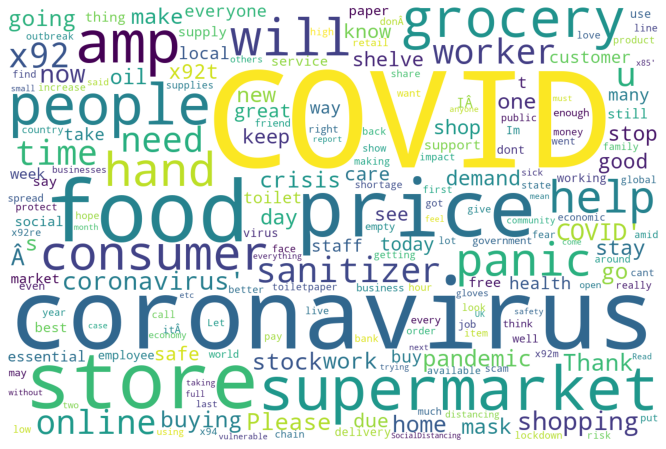

In [19]:
## wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = df2.select('clear_text').sample(fraction = 0.3, seed = 101)
all_words = [text['clear_text'] for text in amostra.collect()]
wordcloud = WordCloud(background_color = 'white',
                      width = 1200,
                      height = 800,
                      collocations = False, 
                      prefer_horizontal = 1).generate(str(all_words))


plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


## ANTES E DEPOIS DA REMOÇÃO DAS STOPWORDS

Comparativo sobre a distribuição dos tokens antes e depois da remoção das stopwords

In [20]:
## antes e depois dos stopwords
import plotly.graph_objs as go
freq_tokens = df2.select('tokens', 'final_text')\
        .withColumn('freq_token', count_token(f.col('tokens')))\
        .withColumn('freq_token_final', count_token(f.col('final_text'))).toPandas()

fig = go.Figure()
fig.add_trace(go.Histogram(x=freq_tokens.freq_token, name = 'Before'))
fig.add_trace(go.Histogram(x=freq_tokens.freq_token_final, name='After'))

# Overlay both histograms
fig.update_layout(barmode='overlay',
                  title_text='StopWords', 
                  xaxis_title_text='Quantity', 
                  yaxis_title_text='Count',
                  width = 800, height = 600 ,title_x=0.45
                  )

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

## VETORIZAÇÃO

É a forma como o modelo vai conseguir 'entender' o texto e conseguir classificá-lo. De forma geral, a função ***CountVectorizer*** irá realizar a contagem das diferentes palavaras da base, criará uma lista com a identificação via número das palavras que aparecem na frase e uma outra lista com a frequência de cada uma dessas palavras. De forma geral:

[total, [identificação das palavras na ordem construída], [frequência de cada palavra]]

Faremos isso na variável df2. A saída ***Vec_Count*** contém a saída da vetorização do nosso texto.


In [21]:
##vetorização
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="final_text", outputCol="Vec_Count")
model = cv.fit(df2)
df2 = model.transform(df2)
df2.select('final_text','Vec_Count').limit(5).show()#truncate=False

+--------------------+--------------------+
|          final_text|           Vec_Count|
+--------------------+--------------------+
|[ready, go, super...|(30498,[1,2,3,5,1...|
|[due, covid, situ...|(30498,[1,3,18,24...|
|[horningsea, cari...|(30498,[12,14,18,...|
|[amazon, glitch, ...|(30498,[1,6,9,14,...|
|[, , nations, inf...|(30498,[0,1,3,31,...|
+--------------------+--------------------+



## TF-IDF

É abreviação do inglês term frequency–inverse document frequency, que significa frequência do termo–inverso da frequência nos documentos. A ideia geral é dar "peso" as palavras mais importantes para a classficação desejada. Faremos isso com a função IDF.

A coluna ***features*** da variável ***TFIDFfeaturizedData*** ilustra esse processo.

In [22]:
#TF-IDF
from pyspark.ml.feature import IDF
idf = IDF(inputCol="Vec_Count", outputCol="features")
idfModel = idf.fit(df2)
TFIDFfeaturizedData = idfModel.transform(df2)
TFIDFfeaturizedData.select('final_text', 'features').limit(5).show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_text                                                                                                                                                     

## CODIFICANDO A VARIÁVEL RESPOSTA

A função StringIndexer faz a codificação da variável de interesse. Ela atribui valores numéricos para os labels.

Faremos a codificação na nossa base original (dados)

In [23]:
from pyspark.ml.feature import StringIndexer
stringindexer = StringIndexer(inputCol="Sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)

dados.show(3)


+--------+--------------------+------------------+--------------------+--------------------+-----+
|UserName|       OriginalTweet|         Sentiment|  remove_punctuation|          clear_text|label|
+--------+--------------------+------------------+--------------------+--------------------+-----+
|    3803|Me, ready to go a...|Extremely Negative|Me ready to go at...|Me ready to go at...|  1.0|
|    3810|Due to the Covid-...|Extremely Positive|Due to the Covid ...|Due to the Covid ...|  0.0|
|    3811|#horningsea is a ...|Extremely Positive|horningsea is a c...|horningsea is a c...|  0.0|
+--------+--------------------+------------------+--------------------+--------------------+-----+
only showing top 3 rows



In [24]:
dados.groupBy(['Sentiment','label']).count().show()

+------------------+-----+-----+
|         Sentiment|label|count|
+------------------+-----+-----+
|Extremely Positive|  0.0| 6624|
|Extremely Negative|  1.0| 5481|
+------------------+-----+-----+



## PIPELINE

Após a ilustração de cada uma das etapas necessárias de preparação da nossa base, vamos criar o pipeline e aplicar cada uma das etaapas na nossa base para a construção de um modelo de classificação.

Lembrando que, após a remoção dos caracteres especiais e dos espacos em branco no início e final de cada tweet, faremos:

* tokenização;

* remoção das stopwords;

* vetorização;

* tf-idf (peso para as palavras).

O pyspark possui a função ***Pipeline*** para facilitar a construção de todo esse processo. A variável ***data_trans*** contém os resultados de cada uma dessas etapas aplicado na nossa base inicial ***dados***.

In [25]:
from pyspark.ml import Pipeline


tokenizer = Tokenizer(inputCol="clear_text", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")
cv = CountVectorizer(inputCol="final_text", outputCol="Vec_Count")
tfidf = IDF(inputCol="Vec_Count", outputCol="features")


pipeline = Pipeline(stages = [tokenizer,stopwords, cv, tfidf])

data_trans = pipeline.fit(dados).transform(dados)

data_trans.show(5)


+--------+--------------------+------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|UserName|       OriginalTweet|         Sentiment|  remove_punctuation|          clear_text|label|              tokens|          final_text|           Vec_Count|            features|
+--------+--------------------+------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|    3803|Me, ready to go a...|Extremely Negative|Me ready to go at...|Me ready to go at...|  1.0|[me, ready, to, g...|[ready, go, super...|(30498,[1,2,3,5,1...|(30498,[1,2,3,5,1...|
|    3810|Due to the Covid-...|Extremely Positive|Due to the Covid ...|Due to the Covid ...|  0.0|[due, to, the, co...|[due, covid, situ...|(30498,[1,3,18,24...|(30498,[1,3,18,24...|
|    3811|#horningsea is a ...|Extremely Positive|horningsea is a c...|horningsea is 

## MODELO DE CLASSIFICAÇÃO

Para a construção do modelo utilizaremos as colunas ***features*** (entrada) e ***label*** (saída). 

Utilizaremos a Regressão Logística.

In [26]:
df_features = data_trans.select(['features', 'label'])
df_features.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [27]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label')


## CROSS VALIDATION

Utilizaremos uma validação cruzada com 3 folds, da seguinte forma:

* **ParamGridBuilder** para construir o grid e testar os parâmetros;

*  **evaluator**: parâmetro necessário para a validação cruzada;

* divisão dos dados em 70% para treino e 30% para teste;

* **CrossValidator** que constroi o objeto para a validação cruzada com os parâmetros descritos;

* **fit** com os dados de treino.

In [28]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.2, 0.5, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [1, 2, 5, 10, 25, 50])
             .build())

evaluator = MulticlassClassificationEvaluator()


train, test = df_features.randomSplit([0.7,0.3], seed=123)
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lrparamGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=123
)

lr_model_cv = lr_cv.fit(train)


## AVALIAÇÃO DO MODELO

Com o modelo construído faremos a predição usando os dados de teste com a função **.transform**.

In [29]:
predictions = lr_model_cv.transform(test)
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(30498,[0],[0.890...|  0.0|[0.13146076874803...|[0.53281794266887...|       0.0|
|(30498,[0],[0.890...|  1.0|[0.13146076874803...|[0.53281794266887...|       0.0|
|(30498,[0,1,2,3,5...|  1.0|[-1.2080425586516...|[0.23004758088300...|       1.0|
|(30498,[0,1,2,3,6...|  0.0|[2.13729566472048...|[0.89447562319595...|       0.0|
|(30498,[0,1,2,3,6...|  1.0|[-0.3544343413385...|[0.41230751948179...|       1.0|
|(30498,[0,1,2,3,6...|  1.0|[-1.4531379670842...|[0.18951909955663...|       1.0|
|(30498,[0,1,2,3,6...|  0.0|[1.84921710708043...|[0.86403515618896...|       0.0|
|(30498,[0,1,2,3,7...|  1.0|[-2.2440559114561...|[0.09586342446115...|       1.0|
|(30498,[0,1,2,3,8...|  0.0|[2.37095972547448...|[0.91458586277631...|       0.0|
|(30498,[0,1,2,3

### ACURÁCIA

A função ***MulticlassClassificationEvaluator*** permite a avaliação do modelo.Vamos usar a acurácia como métrica de análise.

In [30]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
acuracia = evaluator.evaluate(predictions)
acuracia


0.9097335508428493

Nosso modelo apresenta 90,97% de acurácia nos dados de teste.


## MATRIZ DE CONFUSÃO

In [31]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1])
cnf_matrix

array([[1887,  164],
       [ 168, 1459]])

In [34]:
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

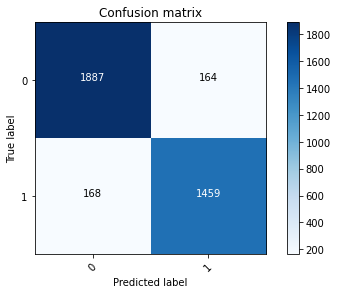

In [35]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')
plt.show()